In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd
import numpy as np

risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

In [18]:
risky_r.shape

(228, 3)

In [19]:
safe_r = pd.DataFrame().reindex_like(risky_r)

In [20]:
safe_r.shape

(228, 3)

In [21]:
safe_r[:] = 0.03/12
star=1000
floor=0.8

##### 1. Cushion - (Asset Value minus Floor Value)
##### 2. Compute an Allocation to Safe and Risky Asset --> m * risk budget
##### 3. Recompute the Asset Value on the returns

In [22]:
def compound1(r):
    return(1+r).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [23]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [24]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [50]:
%timeit compound1(risky_r)

1.32 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
%timeit compound2(risky_r)

386 µs ± 6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Back to CPPI

In [25]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    

In [26]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


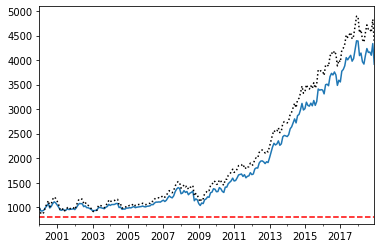

In [27]:
ind = "Beer"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

In [28]:
risky_wealth = start * (1+risky_r).cumprod()

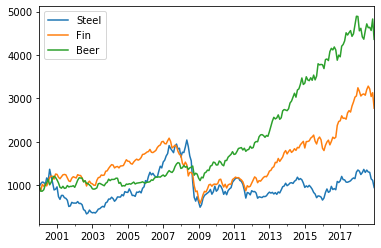

In [29]:
risky_wealth.plot()

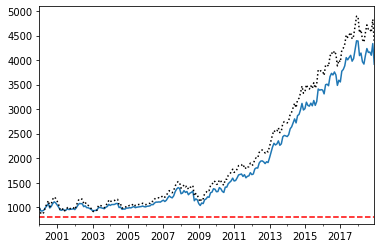

In [32]:
ax = account_history["Beer"].plot()
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

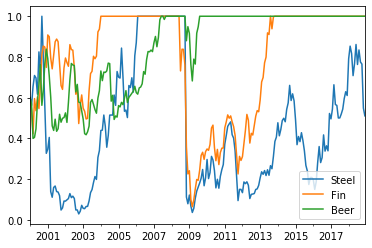

In [33]:
risky_w_history.plot()

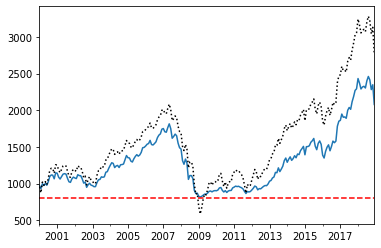

In [35]:
ind="Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

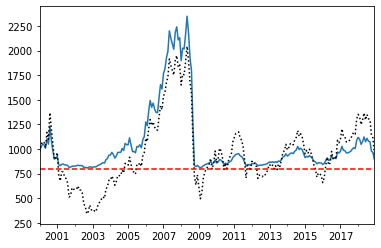

In [36]:
ind="Steel"
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

In [40]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [42]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


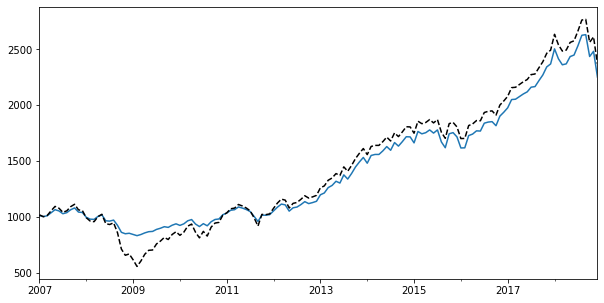

In [58]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

In [55]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [56]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


# Drawdown Constraint

In [59]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)

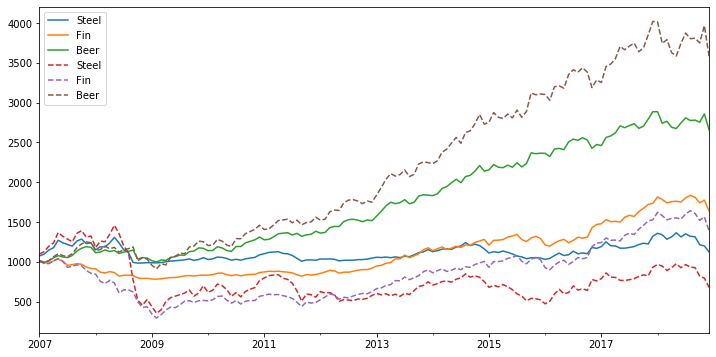

In [60]:
# Portfolio Vs. Precio del activo
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [62]:
# Precio del activo
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [63]:
# Portfolio
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
